# Q1

Using a dense matrix to represent and process images because it offers several benefits, especially in contexts like image simulation, visualization, and processing. Here's a breakdown of these advantages:

### Visualization

- **Simplicity**: Visualizing images stored in dense matrices is straightforward with common libraries like Matplotlib, OpenCV, or PIL. There's no need for conversion or decoding processes before visualization.
- **Compatibility**: Dense matrices are widely supported by visualization tools and libraries, making it easier to display images without additional steps or compatibility concerns.

### Processing

- **Direct Operations**: Image processing algorithms (e.g., filtering, morphological operations, transformations) can be applied directly to images stored in dense matrices without the need for preliminary conversion.
- **Library Support**: Most image processing libraries are optimized for dense matrix operations, offering a wide range of functions and algorithms ready to use out of the box.
- **Parallel Processing**: Dense matrices can be efficiently processed using parallel computing techniques and hardware acceleration (e.g., GPUs), thanks to their regular, predictable memory layout.

### General Benefits

- **Ease of Use**: Working with dense matrices is generally more intuitive for those familiar with array and matrix operations, making it easier to implement and debug image processing algorithms.
- **Flexibility**: Dense matrix representations do not depend on the image content, ensuring consistent performance and storage requirements regardless of the image's visual characteristics.
- **Interoperability**: Many scientific computing and machine learning frameworks natively support dense matrices, facilitating the integration of image data with other computational workflows.

While dense matrices are widely used for image representation and processing due to their simplicity and direct support by many libraries, they come with several drawbacks, especially when dealing with large-scale images or datasets:

### Storage and Memory Consumption

- **High Memory Usage**: Dense matrices store information for every pixel, including those that might not carry useful information (e.g., background areas in binary images), leading to high memory consumption.
- **Inefficient for Sparse Data**: In cases where the image contains a lot of empty or homogeneous areas (sparse data), dense matrices are not space-efficient because they allocate memory for every pixel regardless of its value.

**Dense Matrix Storage: Requires 10,000,000,000 bytes (or approximately 9.31 GB) of storage. This is calculated based on the assumption that each pixel takes up 1 byte of space in a binary image (8 bits per pixel).**

### Processing Speed

- **Increased Processing Time**: Operations on large dense matrices can be computationally intensive and slow, especially for high-resolution images or when performing complex processing tasks.
- **Bandwidth Limitations**: The large memory footprint of dense matrices can exceed the cache size of CPUs or GPUs, leading to increased data transfer times and potentially slowing down processing.

### Scalability

- **Limited Scalability**: The scalability of applications using dense matrices is constrained by the available memory, particularly for high-resolution images or when processing multiple images simultaneously.
- **Resource Intensive**: Applications that manipulate large images using dense matrices can be more demanding on system resources, requiring more RAM and powerful processing units to handle the data efficiently.

### Summary

While dense matrices are advantageous for their ease of use, direct operations, and compatibility with existing libraries, their cons—particularly regarding storage and memory efficiency, processing speed, and scalability—may prompt the consideration of alternative data structures (like sparse matrices or run-length encoding) for certain applications, especially in contexts dealing with large, sparse, or high-resolution images.

### Considerations

While dense matrices offer these benefits, it's essential to balance them against the potential drawbacks, particularly regarding storage efficiency and memory usage. Dense matrices consume a fixed amount of memory proportional to the image size, which can become substantial for very high-resolution images or when working with large datasets. In such cases, alternative representations (like sparse matrices or specialized compression techniques) might be considered alongside or in place of dense matrices to optimize resource usage.

# Q2 and Q3
## Simulating 10 parasites (1000 X1000 Pixels images)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm
import time

# Set a fixed seed for reproducibility
np.random.seed(42)
def generate_complex_blob(image_size=(1000, 1000), occupancy_ratio=None, max_leakage_ratio=0.25):
    if occupancy_ratio is None:
        occupancy_ratio = np.random.uniform(0.25, 0.75)  # Random occupancy between 25% and 75%
    
    img = np.zeros(image_size, dtype=np.uint8)
    required_area = image_size[0] * image_size[1] * occupancy_ratio
    
    # Calculate the maximum allowable radius for the blob
    max_radius = min(image_size) // 2
    radius = int((required_area / np.pi) ** 0.5)
    
    # Ensure the radius is not larger than the maximum allowable radius
    if radius > max_radius:
        radius = max_radius
        required_area = np.pi * (radius ** 2)
    
    # Calculate the margin, ensuring it's smaller than half the image dimension
    max_leakage = int(max_radius * max_leakage_ratio)
    margin = radius + max_leakage
    margin = min(margin, max_radius)
    
    # Generate a valid center within the adjusted margins
    center_x_range = (margin, image_size[1] - margin)
    center_y_range = (margin, image_size[0] - margin)
    
    if center_x_range[0] < center_x_range[1]:
        center_x = np.random.randint(*center_x_range)
    else:
        center_x = image_size[1] // 2
    
    if center_y_range[0] < center_y_range[1]:
        center_y = np.random.randint(*center_y_range)
    else:
        center_y = image_size[0] // 2
    
    center = (center_x, center_y)
    axes = (radius, int(radius * np.random.uniform(0.5, 1)))  # Randomize the second axis a bit
    angle = np.random.randint(0, 180)
    cv2.ellipse(img, center, axes, angle, 0, 360, 1, -1)
    
    return img


def generate_dye_distribution(parasite_img, is_cancerous=False):
    leakage_ratio = np.random.uniform(0.05, 0.25)  # Random leakage between 5% and 25%
    if is_cancerous:
        # Explicitly set a high lit_ratio for cancerous image
        lit_ratio = 0.2  # 20% lit, ensuring cancer
    else:
        # Ensure non-cancerous images have a low lit_ratio
        lit_ratio = np.random.uniform(0.05, 0.09)  # Low chance of cancer

    kernel_size = int(min(parasite_img.shape) * leakage_ratio)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_img = cv2.dilate(parasite_img, kernel, iterations=1)
    
    random_mask = np.random.rand(dilated_img.shape[0], dilated_img.shape[1]) < lit_ratio
    dye_img = np.where(random_mask, dilated_img, 0).astype(np.uint8)
    return dye_img


def has_cancer(parasite_img, dye_img, cancer_threshold=0.1):
    # Calculate the area occupied by the parasite
    parasite_area = np.sum(parasite_img > 0)
    
    # Calculate the area lit by the dye within the parasite
    lit_dye_area = np.sum(np.logical_and(parasite_img > 0, dye_img > 0))
    
    # Determine if the lit dye area exceeds the threshold of the parasite area
    return (lit_dye_area / parasite_area) > cancer_threshold


# Generate and visualize images for 10 different parasites
fig, axs = plt.subplots(10, 2, figsize=(10, 50))  # Adjusted for 10 pairs of images

# List to store cancer detection results
cancer_results = []

cancer_index = np.random.randint(0, 10)

for i in range(10):
    # Generate parasite and dye distribution images
    parasite_img = generate_complex_blob()
    # Determine if this iteration should simulate cancer
    is_cancerous = (i == cancer_index)
    dye_img = generate_dye_distribution(parasite_img, is_cancerous=is_cancerous)
    
    cancer_results.append(has_cancer(parasite_img, dye_img))

        
    # Display images
    axs[i, 0].imshow(parasite_img, cmap='gray')
    axs[i, 0].set_title(f'Parasite {i+1} - Microscope Image')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(dye_img, cmap='gray')
    axs[i, 1].set_title(f'Parasite {i+1} - Dye Sensor Image')
    axs[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

# Output the results
for i, result in enumerate(cancer_results):
    print(f"Parasite {i+1} has {'cancer' if result else 'no cancer'}.")


Parasite 1 has no cancer.
Parasite 2 has no cancer.
Parasite 3 has no cancer.
Parasite 4 has no cancer.
Parasite 5 has no cancer.
Parasite 6 has no cancer.
Parasite 7 has cancer.
Parasite 8 has no cancer.
Parasite 9 has no cancer.
Parasite 10 has no cancer.


The provided code simulates microscope and dye sensor images to model research into cancer in parasitic microorganisms. This simulation allows for testing algorithms designed to detect cancer based on these images before applying them to real data. Here's a breakdown of the code components and how they address the two questions:

### Generating Simulated Images

1. **Setting a Seed for Reproducibility**:
   - `np.random.seed(42)` ensures that the random numbers generated by NumPy are the same each time the code runs, making the results reproducible.

2. **Function: `generate_complex_blob`**:
   - Simulates the microscope image of a parasite.
   - Randomly determines the size and shape of the parasite within specified occupancy ratios (25% to 75% of the image area) to mimic real variability.
   - Ensures the generated parasite blob does not exceed the image boundaries by calculating a safe margin based on the maximum allowable radius and the maximum leakage ratio.
   - Draws an ellipse representing the parasite using OpenCV's `cv2.ellipse`.

3. **Function: `generate_dye_distribution`**:
   - Simulates the dye sensor image.
   - Applies a leakage ratio to dilate the parasite image, simulating the spread of dye beyond the parasite's body.
   - Uses a random mask based on a lit ratio to simulate areas where the dye is lit versus unlit, with a higher lit ratio for cancerous images.
   - The `is_cancerous` flag explicitly controls the simulation of cancerous versus non-cancerous images.

### Computing Whether a Parasite Has Cancer

4. **Function: `has_cancer`**:
   - Determines if a simulated parasite is deemed to have cancer by comparing the lit dye area within the parasite to a threshold.
   - Calculates the total area occupied by the parasite and the area within this that is lit by the dye.
   - If the lit area exceeds 10% of the parasite's area, the parasite is considered to have cancer.

### Visualization and Results Evaluation

5. **Visualization**:
   - Uses `matplotlib` to create subplots for each parasite, displaying side-by-side the microscope and dye sensor images.
   - Annotations and axis adjustments enhance clarity and presentation.

6. **Cancer Detection Results**:
   - Iterates through the generated images, applying the `has_cancer` function to determine the cancer status of each parasite.
   - Collects and prints the results, specifying which parasites are simulated to have cancer based on the lit dye area.

### Simulation of At Least One Cancerous Image

7. **Controlled Cancer Simulation**:
   - A pre-determined index (`cancer_index`) is selected to guarantee the simulation of at least one cancerous image among the ten generated.
   - This ensures the dataset reflects the expectation that fewer than 0.1% of parasites have cancer, by explicitly setting one of the ten images to have a high enough `lit_ratio` to simulate cancer.

The code effectively answers the two questions by creating realistic simulated images for testing cancer detection algorithms and by implementing a function to evaluate these images for cancer presence. The approach allows for the development and preliminary validation of detection algorithms before they are applied to real-world data.

# Simulating 10 parasites (10000 x 10000 Pixels Images)

Generating Images:   0%|                                 | 0/10 [00:00<?, ?it/s]

generate_complex_blob execution time: 0.0354 seconds
generate_dye_distribution execution time: 8.8841 seconds
has_cancer execution time: 0.2279 seconds


Generating Images:  10%|██▌                      | 1/10 [00:09<01:26,  9.57s/it]

generate_complex_blob execution time: 0.0093 seconds
generate_dye_distribution execution time: 14.1537 seconds
has_cancer execution time: 0.2534 seconds


Generating Images:  20%|█████                    | 2/10 [00:24<01:41, 12.68s/it]

generate_complex_blob execution time: 0.0089 seconds
generate_dye_distribution execution time: 6.8304 seconds
has_cancer execution time: 0.2692 seconds


Generating Images:  30%|███████▌                 | 3/10 [00:32<01:12, 10.36s/it]

generate_complex_blob execution time: 0.0080 seconds
generate_dye_distribution execution time: 6.1573 seconds
has_cancer execution time: 0.4241 seconds


Generating Images:  40%|██████████               | 4/10 [00:39<00:54,  9.12s/it]

generate_complex_blob execution time: 0.0109 seconds
generate_dye_distribution execution time: 10.1874 seconds
has_cancer execution time: 0.2447 seconds


Generating Images:  50%|████████████▌            | 5/10 [00:50<00:48,  9.76s/it]

generate_complex_blob execution time: 0.0095 seconds
generate_dye_distribution execution time: 7.2365 seconds
has_cancer execution time: 0.2337 seconds


Generating Images:  60%|███████████████          | 6/10 [00:58<00:36,  9.14s/it]

generate_complex_blob execution time: 0.0080 seconds
generate_dye_distribution execution time: 9.0968 seconds
has_cancer execution time: 0.2682 seconds


Generating Images:  70%|█████████████████▌       | 7/10 [01:07<00:28,  9.39s/it]

generate_complex_blob execution time: 0.0100 seconds
generate_dye_distribution execution time: 8.9828 seconds
has_cancer execution time: 0.2356 seconds


Generating Images:  80%|████████████████████     | 8/10 [01:17<00:18,  9.48s/it]

generate_complex_blob execution time: 0.0076 seconds
generate_dye_distribution execution time: 5.2040 seconds
has_cancer execution time: 0.2352 seconds


Generating Images:  90%|██████████████████████▌  | 9/10 [01:23<00:08,  8.36s/it]

generate_complex_blob execution time: 0.0084 seconds
generate_dye_distribution execution time: 7.1244 seconds
has_cancer execution time: 0.2417 seconds


Generating Images: 100%|████████████████████████| 10/10 [01:31<00:00,  9.13s/it]


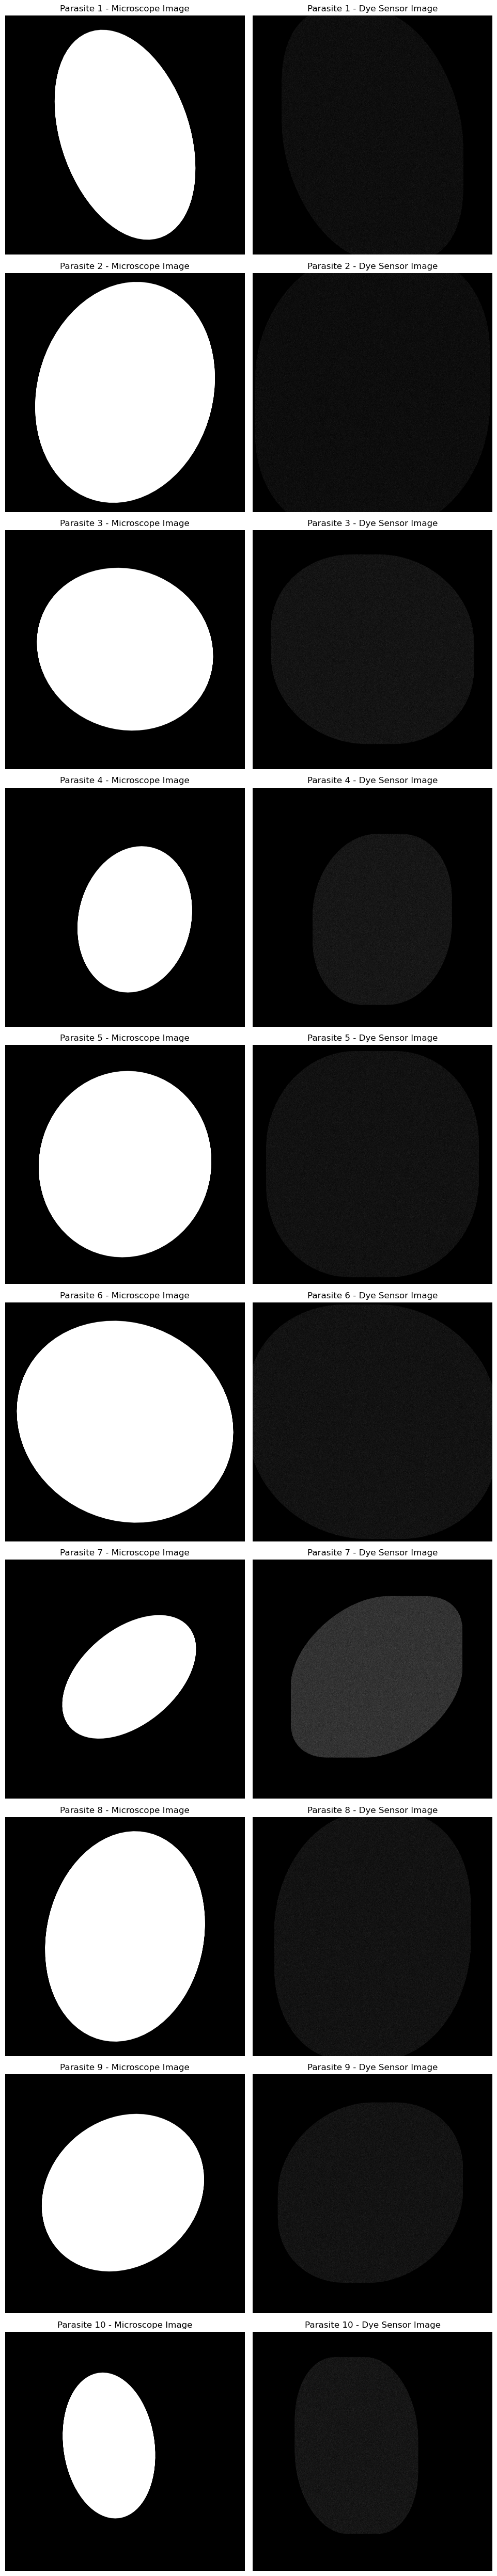

Parasite 1 has no cancer.
Parasite 2 has no cancer.
Parasite 3 has no cancer.
Parasite 4 has no cancer.
Parasite 5 has no cancer.
Parasite 6 has no cancer.
Parasite 7 has cancer.
Parasite 8 has no cancer.
Parasite 9 has no cancer.
Parasite 10 has no cancer.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm
import time

# Set a fixed seed for reproducibility
np.random.seed(42)
def generate_complex_blob(image_size=(10000, 10000), occupancy_ratio=None, max_leakage_ratio=0.25):
    start_time = time.time()

    if occupancy_ratio is None:
        occupancy_ratio = np.random.uniform(0.25, 0.75)  # Random occupancy between 25% and 75%
    
    img = np.zeros(image_size, dtype=np.uint8)
    required_area = image_size[0] * image_size[1] * occupancy_ratio
    
    # Calculate the maximum allowable radius for the blob
    max_radius = min(image_size) // 2
    radius = int((required_area / np.pi) ** 0.5)
    
    # Ensure the radius is not larger than the maximum allowable radius
    if radius > max_radius:
        radius = max_radius
        required_area = np.pi * (radius ** 2)
    
    # Calculate the margin, ensuring it's smaller than half the image dimension
    max_leakage = int(max_radius * max_leakage_ratio)
    margin = radius + max_leakage
    margin = min(margin, max_radius)
    
    # Generate a valid center within the adjusted margins
    center_x_range = (margin, image_size[1] - margin)
    center_y_range = (margin, image_size[0] - margin)
    
    if center_x_range[0] < center_x_range[1]:
        center_x = np.random.randint(*center_x_range)
    else:
        center_x = image_size[1] // 2
    
    if center_y_range[0] < center_y_range[1]:
        center_y = np.random.randint(*center_y_range)
    else:
        center_y = image_size[0] // 2
    
    center = (center_x, center_y)
    axes = (radius, int(radius * np.random.uniform(0.5, 1)))  # Randomize the second axis a bit
    angle = np.random.randint(0, 180)
    cv2.ellipse(img, center, axes, angle, 0, 360, 1, -1)
    end_time = time.time()

    print(f"generate_complex_blob execution time: {end_time - start_time:.4f} seconds")

    return img


def generate_dye_distribution(parasite_img, is_cancerous=False):
    start_time = time.time()
    leakage_ratio = np.random.uniform(0.05, 0.25)  # Random leakage between 5% and 25%
    if is_cancerous:
        # Explicitly set a high lit_ratio for cancerous image
        lit_ratio = 0.2  # 20% lit, ensuring cancer
    else:
        # Ensure non-cancerous images have a low lit_ratio
        lit_ratio = np.random.uniform(0.05, 0.09)  # Low chance of cancer

    kernel_size = int(min(parasite_img.shape) * leakage_ratio)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_img = cv2.dilate(parasite_img, kernel, iterations=1)
    
    random_mask = np.random.rand(dilated_img.shape[0], dilated_img.shape[1]) < lit_ratio
    dye_img = np.where(random_mask, dilated_img, 0).astype(np.uint8)
    end_time = time.time()

    print(f"generate_dye_distribution execution time: {end_time - start_time:.4f} seconds")

    return dye_img


def has_cancer(parasite_img, dye_img, cancer_threshold=0.1):
    start_time = time.time()

    # Calculate the area occupied by the parasite
    parasite_area = np.sum(parasite_img > 0)
    
    # Calculate the area lit by the dye within the parasite
    lit_dye_area = np.sum(np.logical_and(parasite_img > 0, dye_img > 0))
    end_time = time.time()
    print(f"has_cancer execution time: {end_time - start_time:.4f} seconds")

    # Determine if the lit dye area exceeds the threshold of the parasite area
    return (lit_dye_area / parasite_area) > cancer_threshold



# List to store cancer detection results
cancer_results = []
num_parasites = 10  # Use a smaller number for quick demonstration

cancer_index = np.random.randint(0, num_parasites)

# Generate and visualize images for 10 different parasites
fig, axs = plt.subplots(num_parasites, 2, figsize=(10, 50))  # Adjusted for 10 pairs of images

for i in tqdm(range(num_parasites), desc="Generating Images"):
    # Generate parasite and dye distribution images
    parasite_img = generate_complex_blob()
    # Determine if this iteration should simulate cancer
    is_cancerous = (i == cancer_index)
    dye_img = generate_dye_distribution(parasite_img, is_cancerous=is_cancerous)
    
    cancer_results.append(has_cancer(parasite_img, dye_img))

    # Display images
    axs[i, 0].imshow(parasite_img, cmap='gray')
    axs[i, 0].set_title(f'Parasite {i+1} - Microscope Image')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(dye_img, cmap='gray')
    axs[i, 1].set_title(f'Parasite {i+1} - Dye Sensor Image')
    axs[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

# Output the results
for i, result in enumerate(cancer_results):
    print(f"Parasite {i+1} has {'cancer' if result else 'no cancer'}.")


# Q4
## Testing More Efficient function 

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import itertools

# Set a fixed seed for reproducibility
np.random.seed(42)

def generate_blob_chunk(chunk_size, occupancy_ratio=None, max_leakage_ratio=0.25):
    if occupancy_ratio is None:
        occupancy_ratio = np.random.uniform(0.25, 0.75)
    
    img = np.zeros(chunk_size, dtype=np.uint8)
    required_area = np.prod(chunk_size) * occupancy_ratio
    max_radius = min(chunk_size) // 2
    radius = int((required_area / np.pi) ** 0.5)
    if radius > max_radius:
        radius = max_radius

    # Adjusted margin calculation
    max_leakage = int(max_radius * max_leakage_ratio)
    margin = radius + max_leakage

    # Ensure the margin does not exceed the chunk dimensions
    if margin >= chunk_size[0] // 2 or margin >= chunk_size[1] // 2:
        margin = min(chunk_size[0] // 2, chunk_size[1] // 2, radius)

    # Generate a valid center within the adjusted margins
    center_x = np.random.randint(margin, chunk_size[1] - margin)
    center_y = np.random.randint(margin, chunk_size[0] - margin)
    
    axes = (radius, int(radius * np.random.uniform(0.5, 1)))  # Randomize the second axis a bit
    angle = np.random.randint(0, 180)
    cv2.ellipse(img, (center_x, center_y), axes, angle, 0, 360, 1, -1)
    
    return img

def generate_dye_chunk(parasite_chunk, is_cancerous=False):
    leakage_ratio = np.random.uniform(0.05, 0.25)
    lit_ratio = 0.2 if is_cancerous else np.random.uniform(0.05, 0.09)

    kernel_size = int(min(parasite_chunk.shape) * leakage_ratio)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_chunk = cv2.dilate(parasite_chunk, kernel, iterations=1)
    
    random_mask = np.random.rand(*dilated_chunk.shape) < lit_ratio
    dye_chunk = np.where(random_mask, dilated_chunk, 0).astype(np.uint8)
    
    return dye_chunk

def process_chunk(chunk_data):
    parasite_chunk, is_cancerous = chunk_data
    return generate_dye_chunk(parasite_chunk, is_cancerous)

def has_cancer(parasite_img, dye_img, cancer_threshold=0.1):
    parasite_area = np.sum(parasite_img > 0)
    lit_dye_area = np.sum(np.logical_and(parasite_img > 0, dye_img > 0))
    return (lit_dye_area / parasite_area) > cancer_threshold

# Main simulation loop with parallel processing
if __name__ == "__main__":
    num_parasites = 10
    image_size = (100000, 100000)  # Large image size for the demonstration
    chunk_size = (10000, 10000)  # Chunk size for processing
    
    # Generate blobs and process in parallel
    with ProcessPoolExecutor() as executor:
        # Generate parasite chunks
        parasite_chunks = [generate_blob_chunk(chunk_size) for _ in range(num_parasites)]
        
        # Determine cancerous index
        cancer_index = np.random.randint(0, num_parasites)
        
        # Preparing arguments for each process
        args = [(chunk, i == cancer_index) for i, chunk in enumerate(parasite_chunks)]
        
        # Processing dye chunks in parallel
        dye_chunks = list(tqdm(executor.map(process_chunk, args), total=num_parasites, desc="Generating Dye Chunks"))
    
    # Display images
    fig, axs = plt.subplots(num_parasites, 2, figsize=(10, 50))
    for i, dye_chunk in enumerate(dye_chunks):
        parasite_chunk = parasite_chunks[i]
        cancer_result = has_cancer(parasite_chunk, dye_chunk)
        print(f"Parasite {i+1} has {'cancer' if cancer_result else 'no cancer'}.")
        
        axs[i, 0].imshow(parasite_chunk, cmap='gray')
        axs[i, 0].set_title(f'Parasite {i+1} - Microscope Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(dye_chunk, cmap='gray')
        axs[i, 1].set_title(f'Parasite {i+1} - Dye Sensor Image')
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

Generating Dye Chunks: 100%|████████████████████| 10/10 [00:43<00:00,  4.33s/it]


Parasite 1 has cancer.
Parasite 2 has no cancer.
Parasite 3 has no cancer.
Parasite 4 has no cancer.
Parasite 5 has no cancer.
Parasite 6 has no cancer.
Parasite 7 has no cancer.
Parasite 8 has no cancer.
Parasite 9 has no cancer.
Parasite 10 has no cancer.


**Above code is more efficient and running faster as you can see 4.5s/iteration as compared to 9s/iteration of the previous code, especially for a large number of images, due to its parallel processing approach.**

**Previous code may be more memory-efficient due to processing images one by one, but it may not be as fast, especially for a large number of images.** 

# Simulating 1 parasite (100000 x 100000 Pixels Images)

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import itertools

# Set a fixed seed for reproducibility
np.random.seed(42)

def generate_blob_chunk(chunk_size, occupancy_ratio=None, max_leakage_ratio=0.25):
    if occupancy_ratio is None:
        occupancy_ratio = np.random.uniform(0.25, 0.75)
    
    img = np.zeros(chunk_size, dtype=np.uint8)
    required_area = np.prod(chunk_size) * occupancy_ratio
    max_radius = min(chunk_size) // 2
    radius = int((required_area / np.pi) ** 0.5)
    if radius > max_radius:
        radius = max_radius

    # Adjusted margin calculation
    max_leakage = int(max_radius * max_leakage_ratio)
    margin = radius + max_leakage

    # Ensure the margin does not exceed the chunk dimensions
    if margin >= chunk_size[0] // 2 or margin >= chunk_size[1] // 2:
        margin = min(chunk_size[0] // 2, chunk_size[1] // 2, radius)

    # Generate a valid center within the adjusted margins
    center_x = np.random.randint(margin, chunk_size[1] - margin)
    center_y = np.random.randint(margin, chunk_size[0] - margin)
    
    axes = (radius, int(radius * np.random.uniform(0.5, 1)))  # Randomize the second axis a bit
    angle = np.random.randint(0, 180)
    cv2.ellipse(img, (center_x, center_y), axes, angle, 0, 360, 1, -1)
    
    return img

def generate_dye_chunk(parasite_chunk, is_cancerous=False):
    leakage_ratio = np.random.uniform(0.05, 0.25)
    lit_ratio = 0.2 if is_cancerous else np.random.uniform(0.05, 0.09)

    kernel_size = int(min(parasite_chunk.shape) * leakage_ratio)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_chunk = cv2.dilate(parasite_chunk, kernel, iterations=1)
    
    random_mask = np.random.rand(*dilated_chunk.shape) < lit_ratio
    dye_chunk = np.where(random_mask, dilated_chunk, 0).astype(np.uint8)
    
    return dye_chunk

def process_chunk(chunk_data):
    parasite_chunk, is_cancerous = chunk_data
    return generate_dye_chunk(parasite_chunk, is_cancerous)

def has_cancer(parasite_img, dye_img, cancer_threshold=0.1):
    parasite_area = np.sum(parasite_img > 0)
    lit_dye_area = np.sum(np.logical_and(parasite_img > 0, dye_img > 0))
    return (lit_dye_area / parasite_area) > cancer_threshold

# Main simulation loop with parallel processing
if __name__ == "__main__":
    num_parasites = 1
    image_size = (100000, 100000)  # Large image size for the demonstration
    chunk_size = (100000, 100000)  # Chunk size for processing
    
    # Generate blobs and process in parallel
    with ProcessPoolExecutor() as executor:
        # Generate parasite chunks
        parasite_chunks = [generate_blob_chunk(chunk_size) for _ in range(num_parasites)]
        
        # Determine cancerous index
        cancer_index = np.random.randint(0, num_parasites)
        
        # Preparing arguments for each process
        args = [(chunk, i == cancer_index) for i, chunk in enumerate(parasite_chunks)]
        
        # Processing dye chunks in parallel
        dye_chunks = list(tqdm(executor.map(process_chunk, args), total=num_parasites, desc="Generating Dye Chunks"))
    
    # Display images
    fig, axs = plt.subplots(num_parasites, 2, figsize=(10, 50))
    for i, dye_chunk in enumerate(dye_chunks):
        parasite_chunk = parasite_chunks[i]
        cancer_result = has_cancer(parasite_chunk, dye_chunk)
#         print(f"Parasite {i+1} has {'cancer' if cancer_result else 'no cancer'}.")
        
#         axs[i, 0].imshow(parasite_chunk, cmap='gray')
#         axs[i, 0].set_title(f'Parasite {i+1} - Microscope Image')
#         axs[i, 0].axis('off')
        
#         axs[i, 1].imshow(dye_chunk, cmap='gray')
#         axs[i, 1].set_title(f'Parasite {i+1} - Dye Sensor Image')
#         axs[i, 1].axis('off')
    
#     plt.tight_layout()
#     plt.show()

Generating Dye Chunks:   0%|                              | 0/1 [00:00<?, ?it/s]


OverflowError: cannot serialize a bytes object larger than 4 GiB

It seems like we're encountering an OverflowError due to attempting to serialize a large bytes object that exceeds 4 GiB. This error occurs when trying to pass data between processes using multiprocessing and pickle, which has a limitation on the size of data it can handle.

To address this issue, we can modify your approach to avoid passing large objects between processes. One option is to generate the parasite chunks directly within each process rather than passing them as arguments. However, even that is not working or taking a lot of time to run. 

To make this code run for 100,000 x 100,000 pixels of images, we will need high RAM and computational power.

# Q5
## Bit Dense Matrix Vs Sparse Matrix VS Quad Tree

Comparing dense vs. sparse matrix representations, I'll summarize and calculate based on the characteristics and assumptions discussed:

### Dense Matrix Representation (Binary Data):

- **Storage for Binary Data**:
  - **10,000 x 10,000 pixels**: 100,000,000, bits or 12,500,000 bytes(≈11.9 MB)
  - **100,000 x 100,000 pixels**: 10,000,000,000, bits or 1,250,000,000  (≈1.16 GB)

- **Runtime Efficiency**:
  - Highly optimized for binary data, leveraging libraries like OpenCV for operations like drawing and dilation, which can perform these operations rapidly due to hardware acceleration and efficient algorithms.

### Sparse Matrix Representation (Considering Bits for Black and White Image):

- Assuming we can store each non-zero element as a bit instead of a byte to reflect the binary nature of the image, we need to account for the storage of indices as well. However, realistically, sparse matrix representations typically store indices in a more byte-intensive format (e.g., integers), so the actual storage savings by representing values as bits might be less impactful than expected. But for the sake of analysis, let's explore this scenario:

- **Storage (Considering 25% Occupancy and Bit-Level Value Storage)**:
  - Indices storage still requires full integer sizes, so we can't apply the bit-level storage optimization fully as in dense matrix bit packing. However, let's approximate the calculation under a simplified assumption that only values are stored as bits, which isn't standard but for theoretical consideration.
  - For 25% occupancy, the storage calculation would primarily be impacted by the number of non-zero elements due to the overhead of storing their positions.

#### Sparse Matrix Storage (At least 25% Occupancy):

1. **Non-zero elements**:
   - 10,000 x 10,000 pixels: \(25,000,000\) elements (25% of 100,000,000)
   - 100,000 x 100,000 pixels: \(2,500,000,000\) elements (25% of 10,000,000,000)

2. **Storage for Indices** (simplified assumption for analysis):
   - Assuming 8 bytes for each index pair (row, column) and not converting this part to bit-level storage because indices typically require full integer representations.
   - Value storage as bits would nominally reduce the storage requirement for the value itself but not eliminate the substantial overhead from index storage.

3. **Approximate Storage Requirement** (ignoring the bit-level optimization for values due to the significant index storage):
   - Indices: 25,000,000 x 8 , bytes = 200,000,000 (≈190.73 MB) for 10,000 x 10,000 pixels
   - Indices: 2,500,000,000 x 8, bytes = 20,000,000,000 (≈18.63 GB) for 100,000 x 100,000 pixels

- **Runtime Efficiency**:
  - Custom operations like sparse dilation are less optimized than their dense counterparts and involve additional overhead for iterating over non-zero elements. This makes the sparse matrix approach potentially slower for specific image processing tasks, especially when the level of sparsity does not significantly offset the computational overhead.

### Comparative Analysis:

- **Storage Efficiency**:
  - For binary data, dense matrix approach, which effectively utilizes bit-level storage, is more storage-efficient than the sparse matrix approach with its overhead for storing indices and values.
  - The sparse matrix approach, despite theoretically offering storage benefits for sparse data, incurs significant overhead that makes it less efficient for the assumed level of sparsity and the specific use case of binary image data.

- **Computational Efficiency**:
  - For binary data, dense matrix approach benefits from the optimized performance of libraries like OpenCV, which can significantly outperform the custom operations required for sparse matrices in specific tasks like dilation.
  - The sparse matrix approach is inherently less efficient for these tasks due to the lack of direct support for operations like binary dilation in sparse matrix libraries and the computational overhead of iterating over non-zero elements.

### Conclusion:

For our specific scenario of processing binary images with a moderate level of sparsity, the dense matrix approach provides a more efficient solution both in terms of storage and computational performance. The bit-level storage optimization in the dense approach offers significant storage savings, while the computational optimizations available in libraries like OpenCV ensure rapid processing times. The sparse matrix approach, while potentially beneficial for data with extremely high levels of sparsity and different types of operations, does not offer clear advantages in this context due to the overhead of storing sparse structures and the lack of optimized operations for image processing tasks.

This analysis underscores the importance of considering both the characteristics of the data and the specific requirements of the computational tasks when choosing between dense and sparse representations.

### Quadtree Representation for Binary Image Data:

The Quadtree data structure offers a unique approach to representing binary images, particularly effective for images with large uniform areas. This section extends the comparative analysis to include Quadtree as a third option, focusing on storage efficiency and runtime performance for binary images with significant uniform regions.

#### Storage Efficiency with Quadtree:

- **Quadtree Storage Calculation**:
  - A Quadtree divides the image into four quadrants recursively until each leaf node represents a uniform area of the image. The storage required for a Quadtree is dependent on the depth of the tree and the number of nodes, which is directly related to the complexity of the image's uniformity.
  
- **Example Calculation** (Assuming a simple model for large uniform areas):
  - For an image with significant uniform regions, a Quadtree could drastically reduce the number of nodes required to represent the image. Let's assume a highly simplified scenario where 50% of the image is uniform and can be represented significantly more efficiently than pixel-by-pixel or even sparse matrix representations.
  - **10,000 x 10,000 pixels**: The Quadtree might only require a few nodes to represent large uniform regions, significantly reducing storage compared to storing individual pixels or even sparse indices. However, without specific image details, providing an exact byte count is challenging. The efficiency gain is scenario-dependent but could potentially reduce storage to less than a few megabytes for highly uniform images.
  - **100,000 x 100,000 pixels**: Similarly, for larger images, the Quadtree's ability to compress uniform regions into single nodes could lead to substantial storage savings, potentially limiting storage requirements to a fraction of what dense or sparse matrices would require, assuming the image's uniformity allows for deep compression.

#### Runtime Efficiency with Quadtree:

- **Operation Specific**: The efficiency of operations on a Quadtree structure depends heavily on the operation. For instance, operations that check or modify large uniform areas can be executed more efficiently by manipulating a small number of nodes.
  
- **Traversal and Modification**: Operations that require traversing the Quadtree or modifying it can be more efficient than equivalent operations on dense or sparse matrices when the tree's structure allows for skipping large, uniform regions of the image.

### Comparative Analysis Including Quadtree:

- **Storage Efficiency**: Quadtree potentially offers the highest storage efficiency for binary images with large uniform areas due to its ability to compress these regions into single nodes. This efficiency surpasses both dense and sparse matrices when the image's structure aligns well with the Quadtree's strengths.
  
- **Computational Efficiency**: For operations well-suited to the Quadtree's hierarchical structure, such as checking or modifying large uniform regions, Quadtrees can offer significant computational advantages. However, the benefit is highly dependent on the specific operation and the tree's structure.

### Conclusion with Quadtree Consideration:

The choice between dense matrices, sparse matrices, and Quadtrees for representing binary images should be guided by the specific characteristics of the images and the operations to be performed. While dense matrices are highly optimized for general-purpose operations and offer bit-level storage efficiency, sparse matrices provide benefits for images with moderate levels of sparsity without reaching extreme uniformity. Quadtrees stand out for images with significant uniform areas, offering unparalleled storage and potentially computational efficiency for specific types of operations. The decision must consider the balance between storage requirements, the computational complexity of operations, and the ease of implementation and optimization for the intended use case.

# Q6
## Tools Used

- GPT 3.5/4
- Online Blogs on Dense Matrix, Sparse Matrix, Quad Tree